In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

tf.__version__

'1.13.1'

In [3]:
content_path = '/home/dev-02/Documentos/Study/style-transfer/assets/contents/content_1.jpg'
style_path = '/home/dev-02/Documentos/Study/style-transfer/assets/Vassily_Kandinsky,_1913_-_Composition_7.jpg'

In [4]:
from src.utils import enable_tf_eager

enable_tf_eager(tf)

Eager execution: True


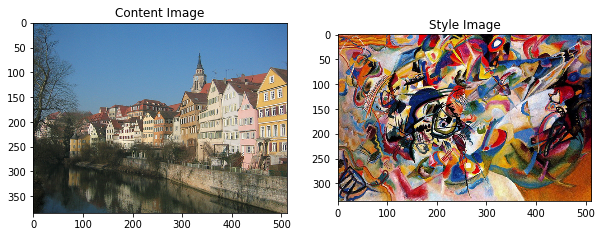

In [5]:
from src.utils import load_img, show_img

plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
show_img(content, 'Content Image')

plt.subplot(1, 2, 2)
show_img(style, 'Style Image')

# Definir e criar nossas funções de perda (distâncias de conteúdo e estilo)

## Perda de Conteúdo:

Nossa definição de perda de conteúdo é bastante simples. Vamos passar para a rede tanto a imagem de conteúdo desejada, quanto a nossa imagem de entrada base.

Isso retornará as saídas da camada intermediária do nosso modelo. Então, simplesmente tomamos a distância euclidiana entre as duas representações intermediárias dessas imagens.

Mais formalmente, a perda de conteúdo é uma função que descreve a distância do conteúdo de nossa imagem de entrada 'X' e a nossa imagem de conteúdo, P. 

Seja Cₙₙ uma rede neural convolucional profunda pré-treinada. Novamente, neste caso, usamos o VGG19 . Seja X qualquer imagem, então Cₙₙ (x) é a rede alimentada por X. Seja Fˡᵢⱼ (x) ∈ Cₙₙ (x) e Pˡᵢⱼ (x) ∈ Cₙₙ (x) descreva a respectiva representação característica intermediária da rede com entradas x e p na camada l.Então, descrevemos a distância do conteúdo (perda) formalmente como:

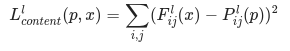

Realizamos o *backpropagation* da maneira usual, de forma que minimizemos essa perda de conteúdo. Assim, alteramos a imagem inicial até gerar uma resposta semelhante em uma determinada camada (definida em content_layer) como a imagem do conteúdo original.

[1] Isso pode ser implementado de maneira simples. Mais uma vez, ele terá como entrada o *feature map* em uma camada L em uma rede alimentada por X, nossa imagem de entrada e P, nossa imagem de conteúdo e retorna a distância do conteúdo.

## Perda de Estilo:

Matematicamente, descrevemos a perda de estilo da imagem de entrada base X e da imagem de estilo A como a distância entre a representação de estilo dessas imagens (the gram matrices). 

## A descida do Gradiente

Usarei o Adam Optimizer para minimizar a nossa loss. 

O foco é atualizar iterativamente nossa imagem de saída de forma a minimizar nossa perda: não atualizamos os pesos associados à nossa rede, mas sim treinamos nossa imagem de entrada para minimizar a perda.

Para fazer isso, devemos saber como calculamos nossa loss e gradients.

In [6]:
from src.utils import *
from src.utils import deprocess_img

In [7]:
def  get_content_loss(base_content, target): #[1]
      return tf.reduce_mean(tf.square(base_content - target))
    
def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    
    from src.utils import gram_matrix
    
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [8]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def get_feature_representations(model, content_path, style_path):
    """
    Esta função irá simplesmente carregar e pré-processar o conteúdo e o estilo.
    Em seguida, ele irá alimentá-los através da rede para obter as saídas das camadas intermediárias. 
    """
    
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

    return style_features, content_features

In [10]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    
    return loss, style_score, content_score

In [11]:
def compute_grads(model,loss_weights, init_image, gram_style_features, content_features):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(model,loss_weights, init_image, gram_style_features, content_features)
        
        # Compute gradients wrt input image
        total_loss = all_loss[0]
        
        return tape.gradient(total_loss, init_image), all_loss

In [12]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2): 
  
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model(style_layers, content_layers) 
    
    for layer in model.layers:
        layer.trainable = False
  
    # Pegando os style e content features (a partir da nossas camadas intermediárias especificadas) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Definindo a imagem inicial:
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32) #tensorflow eager
    
    # Criando o otimizador:
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # Contador para nos auxiliar com as impressões das imagems:
    iter_count = 1

    best_loss, best_img = float('inf'), None
  
    loss_weights = (style_weight, content_weight)
    
    # Para auxílio de apresentações dos resultados:
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(num_iterations):
        
        grads, all_loss = compute_grads(
            model,
            loss_weights,
            init_image,
            gram_style_features,
            content_features
        )
        
        loss, style_score, content_score = all_loss
        
        opt.apply_gradients([(grads, init_image)])
        
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        
        init_image.assign(clipped)
        
        end_time = time.time() 
    
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()
      
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            
            
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

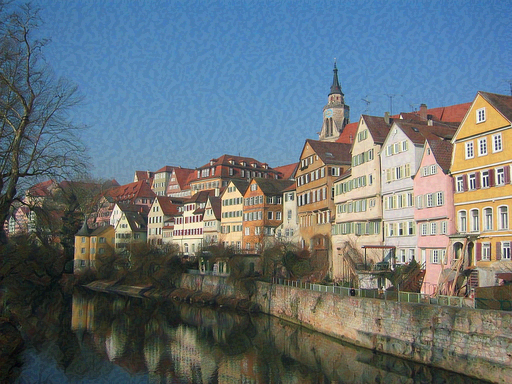

Iteration: 0
Total loss: 1.0400e+09, style loss: 1.0400e+09, content loss: 0.0000e+00, time: 0.0664s


KeyboardInterrupt: 

In [13]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)